# Data

The sentiment analysis model within this notebook uses publicly available datasets:

1. Large Movie Review Dataset: https://ai.stanford.edu/~amaas/data/sentiment/
2. Sentiment Polarity Dataset (v1 and v2): https://www.cs.cornell.edu/people/pabo/movie-review-data/
3. Rotten Tomatoes web scraped critic reviews: https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset/

All data is contained in the "data" directory (not committed in this repo).
The code below assumes the same directory structure as the original datasets under the root "data" folder.

In [76]:
import os
from dataset_utils import *

train_path = os.path.join(IMDB_DATA_PATH, "train")
test_path  = os.path.join(IMDB_DATA_PATH, "test")

"""
For details on implementation of dataset loading and other utils check out dataset_utils.py

CONVENTION: label 0 --> negative review
            label 1 --> positive review
"""

#Main training set - Large Movie Review Dataset (IMDB)
((imdb_train_texts, imdb_train_labels), (imdb_test_texts, imdb_test_labels)) = load_imdb_dataset(train_path=train_path, test_path=test_path)

#Review Polarity Datasets
(v1_texts, v1_labels), (v2_texts, v2_labels) = load_polarity(v1_path=POLARITY_v1_DATA_PATH, v2_path=POLARITY_v2_DATA_PATH)

#Rotten tomatoes critic dataset
rotten_train_texts, rotten_train_labels, short_rotten_test, random_rotten_test, pos_rotten_test, neg_rotten_test = load_rotten_split(ROTTEN_PATH)

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def plot_len_dist(dataset_name, texts):
    data=[len(text) for text in texts]
    median = np.median(data)
    plt.hist(data, 50)
    plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.text(median + 0.5, 50, f'Median: {median:.2f}', color='red', fontsize=10)
    plt.title(f"Length of sample over number of samples: {dataset_name}")
    plt.xlabel("Length of a sample")
    plt.ylabel("Number of samples")
    plt.show()
    
def plot_wordcount_dist(dataset_name, texts):
    data=[len(text.split(" ")) for text in texts]
    median=np.median(data)
    plt.hist(data, 50)
    plt.axvline(x=median, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plt.text(median + 0.5, 50, f'Median: {median:.2f}', color='red', fontsize=10)
    plt.title(f"Number of words: {dataset_name}")
    plt.xlabel("Number of words in a sample")
    plt.ylabel("Number of samples")
    plt.show()

# for title, texts in [('IMDB_train', imdb_train_texts), ('IMDB_test', imdb_test_texts), ('polarity_v1', v1_texts), ('polarity_v2',v2_texts),
#                      ('rotten_train', rotten_train_texts), ('rotten_test', rotten_test_texts)]:
#     plot_len_dist(title, texts)
#     plot_wordcount_dist(title, texts)
    

In [78]:
def display_dataset_info(texts, labels, name):
    print(f"Dataset: {name}.")
    print(f"Total number of samples: {len(texts)}")
    print(f"Positive reviews total: {sum(label==1 for label in labels)}")
    print(f"Negative reviews total: {sum(label==0 for label in labels)}")
    print("--------------------------------------")

for texts, labels, name in [(imdb_train_texts, imdb_train_labels, 'imdb_train'), (imdb_test_texts, imdb_test_labels, 'imdb_test'),
                            (v1_texts, v1_labels, 'polarity_v1'), (v2_texts, v2_labels, 'polarity_v2'),
                            (rotten_train_texts, rotten_train_labels, 'rotten tomatoes train')]:
    
    display_dataset_info(texts, labels, name)

Dataset: imdb_train.
Total number of samples: 25000
Positive reviews total: 12500
Negative reviews total: 12500
--------------------------------------
Dataset: imdb_test.
Total number of samples: 25000
Positive reviews total: 12500
Negative reviews total: 12500
--------------------------------------
Dataset: polarity_v1.
Total number of samples: 10662
Positive reviews total: 5331
Negative reviews total: 5331
--------------------------------------
Dataset: polarity_v2.
Total number of samples: 2000
Positive reviews total: 1000
Negative reviews total: 1000
--------------------------------------
Dataset: rotten tomatoes train.
Total number of samples: 20000
Positive reviews total: 10000
Negative reviews total: 10000
--------------------------------------


In [79]:
from sklearn.model_selection import train_test_split

train_texts_v1, test_texts_v1, train_labels_v1, test_labels_v1 = train_test_split(v1_texts, v1_labels, test_size=0.33, random_state=42)

train_texts = imdb_train_texts + rotten_train_texts + train_texts_v1
train_labels = imdb_train_labels + rotten_train_labels + train_labels_v1

seed=10
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)

print(f"Training set size: {len(train_texts)}")

Training set size: 52143


In [80]:
short_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) < 25]
rest_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) >= 25]
short_test = short_test_v1 + short_rotten_test

long_test_v2 = [(v2_labels[index], text) for index, text in enumerate(v2_texts) if len(text.split(" ")) > 300]
long_test_imdb = [(imdb_test_labels[index], text) for index, text in enumerate(imdb_test_texts) if len(text.split(" ")) > 300]

long_test = long_test_v2 + long_test_imdb

In [81]:
random.seed(seed)
random.shuffle(short_test)
random.seed(seed)
random.shuffle(long_test)

In [82]:
import torch

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif


MAX_FEATURES = 5000

transformer_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=10, ngram_range=(1,2))),
    ('select', SelectKBest(k=MAX_FEATURES, score_func=f_classif))
])

transformed_train = transformer_pipeline.fit_transform(train_texts, train_labels)

X_train = torch.from_numpy(transformed_train.toarray()).to(dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)

vectorizer = transformer_pipeline.named_steps['vect']
selector   = transformer_pipeline.named_steps['select']

In [83]:
from torch import nn

input_dim = X_train.shape[1]

class SentimentCLF1(nn.Module):
    def __init__(self, n_hidden, n_units, dropout_p):
        super().__init__()
        
        self.linear_stack = nn.Sequential(nn.Linear(input_dim, n_units), nn.ReLU())
        
        for _ in range(n_hidden):
            self.linear_stack.append(nn.Linear(n_units, n_units))
            self.linear_stack.append(nn.ReLU())
        
        self.linear_stack.append(nn.Linear(n_units, 1))
                    
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, x):
        dropped = self.dropout(x)
        logits = self.linear_stack(dropped)
        
        return logits
    

class SentimentCLF(nn.Module):
    def __init__(self, n_units, dropout_p):
        super().__init__()
        
        self.linear_stack = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.ReLU()
        ) 
                    
        self.dropout = nn.Dropout(p=dropout_p)
        
        self.final_linear = nn.Linear(n_units, 1)

    def forward(self, x):
        out = self.linear_stack(x)
        dropped = self.dropout(out)
        logits = self.final_linear(dropped)
        
        return logits

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using: {device}")

Using: cuda


In [85]:
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint, LoadInitState

cp = Checkpoint(monitor='valid_loss_best', dirname='models')
load_state = LoadInitState(cp)

net = NeuralNetClassifier(
    module=SentimentCLF,
    module__n_units=400,
    module__dropout_p=0.4,
    #module__n_hidden=3,
    lr = 0.0001,
    criterion=nn.BCEWithLogitsLoss,   
    device=device,
    max_epochs=15,
    optimizer=torch.optim.Adam,
    batch_size=64,
    callbacks=[cp]
)

net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6332       0.8000        0.5379     +  2.2651
      2        0.4693       0.8229        0.4225     +  2.1795
      3        0.3928       0.8289        0.3806     +  2.2144
      4        0.3589       0.8341        0.3620     +  2.2057
      5        0.3401       0.8369        0.3522     +  2.3488
      6        0.3274       0.8395        0.3467     +  2.3087
      7        0.3182       0.8408        0.3434     +  2.2443
      8        0.3111       0.8421        0.3417     +  2.1401
      9        0.3057       0.8436        0.3407     +  2.1309
     10        0.3010       0.8426        0.3404     +  2.1183
     11        0.2974       0.8425        0.3406        2.1561
     12        0.2932       0.8418        0.3410        2.1627
     13        0.2906       0.8416        0.3417        2.1936
     14        0.2871       0.8410        0.3425       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SentimentCLF(
    (linear_stack): Sequential(
      (0): Linear(in_features=5000, out_features=400, bias=True)
      (1): ReLU()
    )
    (dropout): Dropout(p=0.4, inplace=False)
    (final_linear): Linear(in_features=400, out_features=1, bias=True)
  ),
)

In [93]:
#net.initialize()
net.load_params(checkpoint=cp)

In [87]:
# from sklearn.model_selection import GridSearchCV

# net.set_params(train_split=False, verbose=0)

# param_grid = {
#     'module__dropout_p': [0.6],
#     'module__n_units': [100, 500, 1000],
#     'module__n_hidden': [1, 2, 3],
#     'lr': [0.0001]
# }

# gs = GridSearchCV(net, param_grid=param_grid, refit=False, cv=3, scoring='accuracy', verbose=3)
# gs.fit(X_train, y_train)
# print(gs.best_score_, gs.best_params_)
# net.set_params(**gs.best_params_)

# Testing

### Sets:
- IMDB: Small, medium, large
- Short reviews (in terms of number of tokens): Small, large
- Long reviews
- Rotten reviews, mixed (rotten are mostly short reviews)

In [88]:
#Splitting the imdb test reviews and their label into 3 datasets based on size:
#small-1000, medium-5000, large-19000
imdb_small_test_texts  = imdb_test_texts[:1000]
imdb_small_test_labels = imdb_test_labels[:1000]

imdb_medium_test_texts  = imdb_test_texts[1000:6000]
imdb_medium_test_labels = imdb_test_labels[1000:6000]

imdb_large_test_texts  = imdb_test_texts[6000:]
imdb_large_test_labels = imdb_test_labels[6000:]

#Splitting the short reviews dataset into 2 - sm and large 
short_test_sm = short_test[:3000]
short_test_lg = short_test[3000:]

short_test_sm_texts  = [text for _, text in short_test_sm]
short_test_sm_labels = [label for label, _ in short_test_sm]

short_test_lg_texts  = [text for _, text in short_test_lg]
short_test_lg_labels = [label for label, _ in short_test_lg]

In [89]:
def encode_test_set(texts, labels):
    
    X = torch.from_numpy(transformer_pipeline.transform(texts).toarray()).to(dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.float32)
    
    return (X, y)       

In [90]:
#Encoding all test datasets

X_imdb_sm_test = torch.from_numpy(transformer_pipeline.transform(imdb_small_test_texts).toarray()).to(dtype=torch.float32)
X_imdb_md_test = torch.from_numpy(transformer_pipeline.transform(imdb_medium_test_texts).toarray()).to(dtype=torch.float32)
X_imdb_lg_test = torch.from_numpy(transformer_pipeline.transform(imdb_large_test_texts).toarray()).to(dtype=torch.float32)

y_imdb_sm_test = torch.tensor(imdb_small_test_labels, dtype=torch.float32)
y_imdb_md_test = torch.tensor(imdb_medium_test_labels, dtype=torch.float32)
y_imdb_lg_test = torch.tensor(imdb_large_test_labels, dtype=torch.float32)

X_short_sm_test = torch.from_numpy(transformer_pipeline.transform(short_test_sm_texts).toarray()).to(dtype=torch.float32)
X_short_lg_test = torch.from_numpy(transformer_pipeline.transform(short_test_lg_texts).toarray()).to(dtype=torch.float32)

y_short_sm_test = torch.tensor(short_test_sm_labels, dtype=torch.float32)
y_short_lg_test = torch.tensor(short_test_lg_labels, dtype=torch.float32)

X_rotten_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in random_rotten_test]).toarray()).to(dtype=torch.float32)
y_rotten_test = torch.tensor([label for label, _ in random_rotten_test], dtype=torch.float32)

X_long_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in long_test]).toarray()).to(dtype=torch.float32)
y_long_test = torch.tensor([label for label, _ in long_test], dtype=torch.float32)

X_v1_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in rest_test_v1]).toarray()).to(dtype=torch.float32)
y_v1_test = torch.tensor([label for label, _ in rest_test_v1], dtype=torch.float32)

X_v2_test = torch.from_numpy(transformer_pipeline.transform(v2_texts).toarray()).to(dtype=torch.float32)
y_v2_test = torch.tensor(v2_labels, dtype=torch.float32)

X_pos_only_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in pos_rotten_test]).toarray()).to(dtype=torch.float32)
y_pos_only_test = torch.tensor([label for label, _ in pos_rotten_test], dtype=torch.float32)

X_neg_only_test = torch.from_numpy(transformer_pipeline.transform([text for _, text in neg_rotten_test]).toarray()).to(dtype=torch.float32)
y_neg_only_test = torch.tensor([label for label, _ in neg_rotten_test], dtype=torch.float32)

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score

test_sets = [(X_imdb_sm_test, y_imdb_sm_test, 'imdb_sm'), (X_imdb_md_test, y_imdb_md_test, 'imdb_md'), (X_imdb_lg_test, y_imdb_lg_test, 'imdb_lg'),
             (X_short_sm_test, y_short_sm_test, 'short_sm'), (X_short_lg_test, y_short_lg_test, 'short_lg'),
             (X_rotten_test, y_rotten_test, 'rotten_mix'), (X_long_test, y_long_test, 'long (v2+imdb)'),
             (X_v1_test, y_v1_test, 'rest v1 test (more than 25 tokens)'), (X_v2_test, y_v2_test, 'entire v2'),
             (X_pos_only_test, y_pos_only_test, 'positive only (rotten)'), (X_neg_only_test, y_neg_only_test, 'negative only (rotten)')]


"""
The main single-number metric we're checking is accuracy. We show the confusion matrix on each test set as well as the precision score.
Precision metric answers the question "What proportion of positive predictions were classified correctly?". The reason we check is that the model tends to
mislabel reviews that were actually negative.
"""

def test_loop(X, y, set_name, model):
    print(f"DATASET: {set_name}")
    
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    print(f"Accuracy score: {acc}")
    print(f"Precision score: {precision}")
    disp.plot()
    plt.show()
    
    print('-----------------------------------------------------')

DATASET: imdb_sm
Accuracy score: 0.903
Precision score: 0.930327868852459


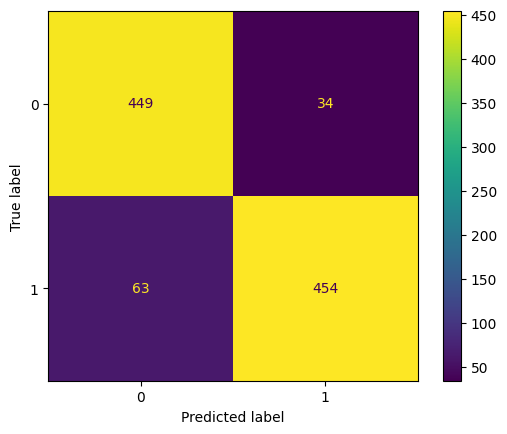

-----------------------------------------------------
DATASET: imdb_md
Accuracy score: 0.909
Precision score: 0.9144342263094762


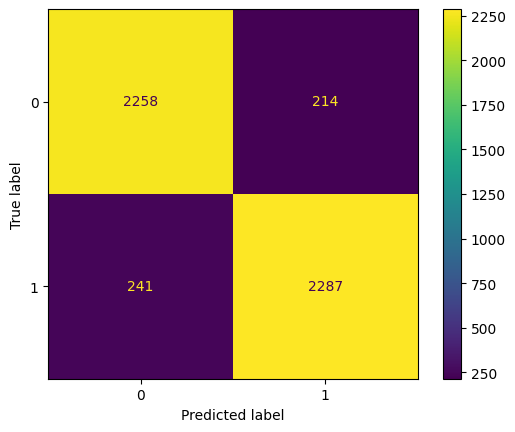

-----------------------------------------------------
DATASET: imdb_lg
Accuracy score: 0.899578947368421
Precision score: 0.9030225355121222


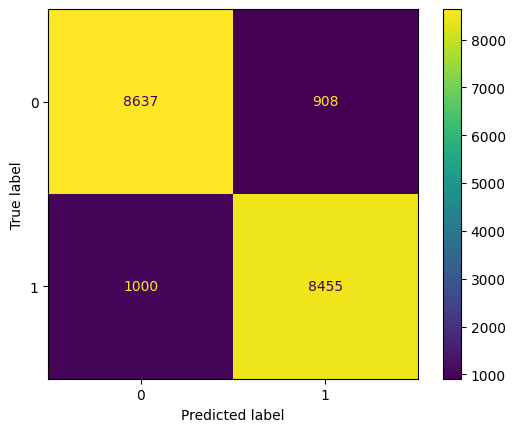

-----------------------------------------------------
DATASET: short_sm
Accuracy score: 0.763
Precision score: 0.8322188449848025


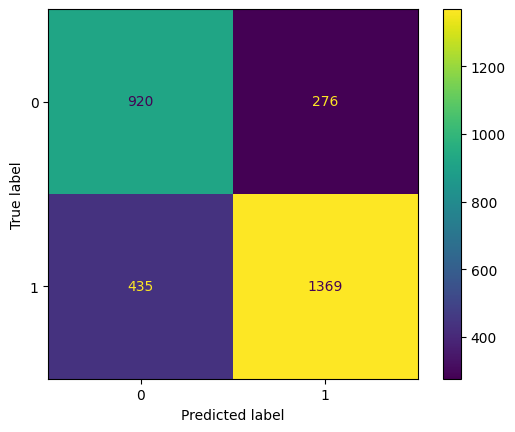

-----------------------------------------------------
DATASET: short_lg
Accuracy score: 0.7697654213727194
Precision score: 0.8484544359694902


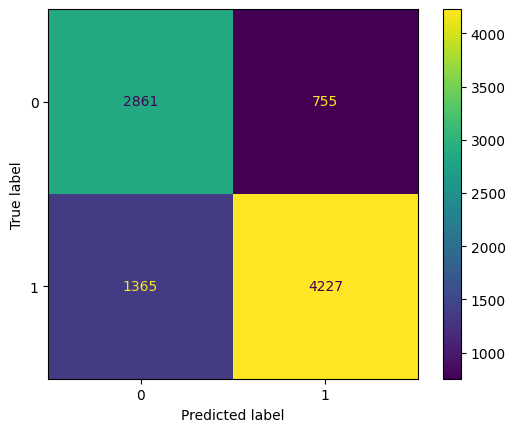

-----------------------------------------------------
DATASET: rotten_mix
Accuracy score: 0.7572
Precision score: 0.8502919837196956


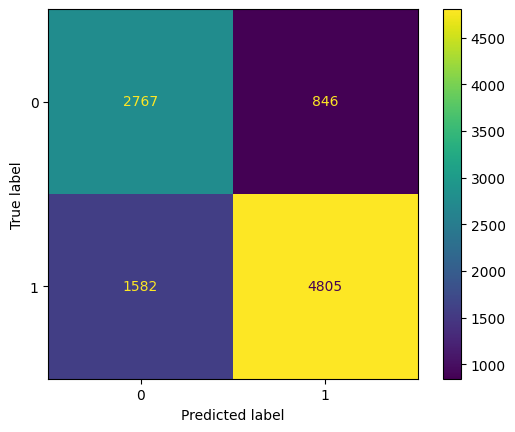

-----------------------------------------------------
DATASET: long (v2+imdb)
Accuracy score: 0.9004056511400196
Precision score: 0.9050971557307801


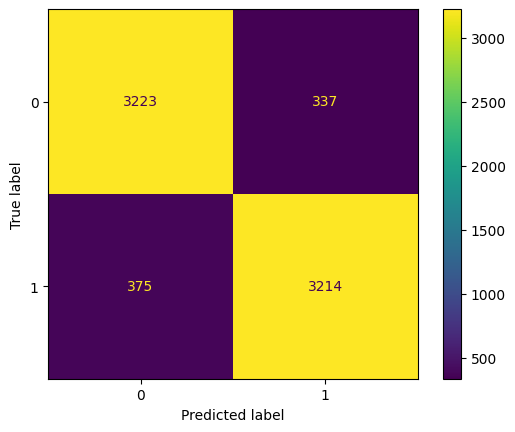

-----------------------------------------------------
DATASET: rest v1 test (more than 25 tokens)
Accuracy score: 0.7643020594965675
Precision score: 0.7601744186046512


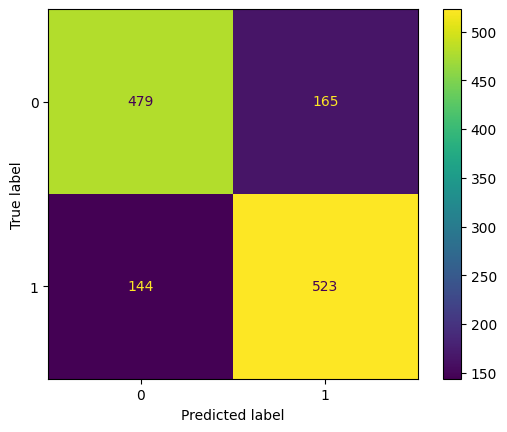

-----------------------------------------------------
DATASET: entire v2
Accuracy score: 0.904
Precision score: 0.9147843942505134


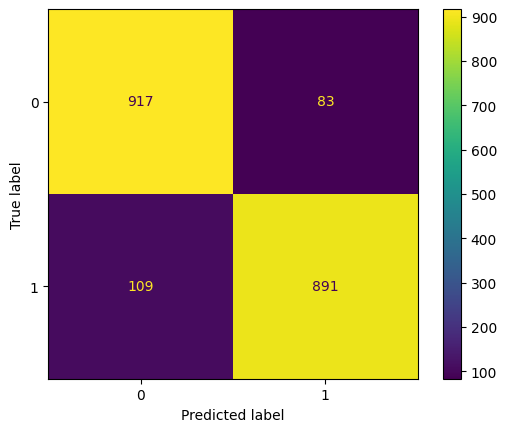

-----------------------------------------------------
DATASET: positive only (rotten)
Accuracy score: 0.774
Precision score: 1.0


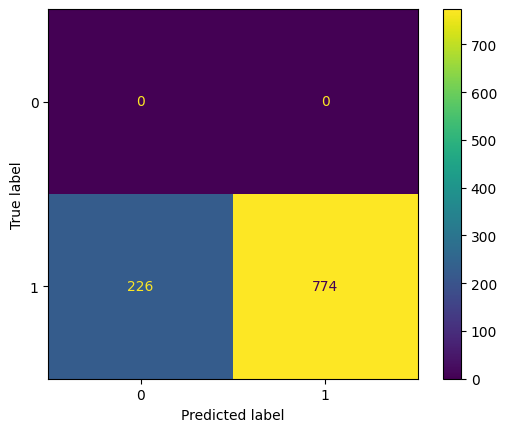

-----------------------------------------------------
DATASET: negative only (rotten)
Accuracy score: 0.77
Precision score: 0.0


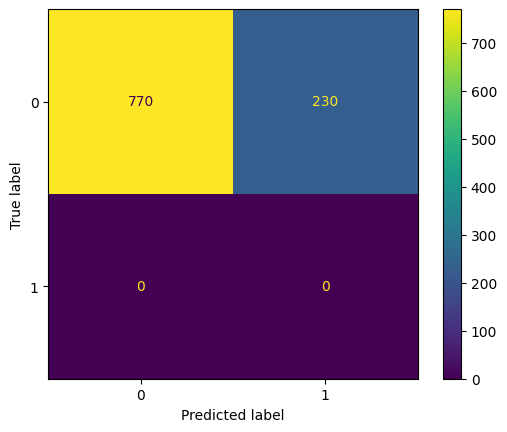

-----------------------------------------------------


In [92]:
for (X_test, y_test, name) in test_sets:
    test_loop(X_test, y_test, set_name=name, model=net)

Initial conclusion: model tends to mislabel mostly negative reviews, thinking they're positive. It could be due to statements like:
*Despite the good cinematography and competent X actor's performance, the movie lacks a gripping narrative and a point to exist besides making money.*

In a review like this, most adjectives are positive bc of the structure like "Some things good, v important thing bad, therefore movie bad"